In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import time
from sklearn.metrics import accuracy_score
import itertools
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Exploratory Data Analysis

In [103]:
#Read in the tweets dataset
data = pd.read_csv("data/BBC News Train.csv")
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


### Ordering by category
The following code will find the different categories and count how many articles belong to each category.

In [110]:
data['category_id'] = data['Category'].factorize()[0]
data['category_id'][0:10]

0    0
1    0
2    0
3    1
4    0
5    2
6    3
7    4
8    0
9    4
Name: category_id, dtype: int64

In [115]:
category_id_df = data[['Category', 'category_id']].drop_duplicates().sort_values('category_id')

category_id_df['Category'].values

'business'

In [108]:
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

print(id_to_category)
print(category_to_id)

{0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}
{'business': 0, 'tech': 1, 'politics': 2, 'sport': 3, 'entertainment': 4}


<AxesSubplot:xlabel='Category'>

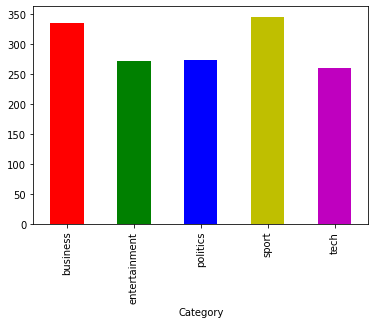

In [85]:
#Count of articles for each category
data.groupby('Category').category_id.count()
my_colors = list('rgbymck')
data.groupby('Category').category_id.count().plot.bar(ylim=0,color=my_colors )

### TF-IDF Vectorization
TF-IDF stands for “Term Frequency — Inverse Document Frequency”. It's a technique to quantify words in a set of documents. It is easier for any programming language to understand textual data in the form of numerical value. That's why we need to vectorize all of the text so that it is better represented. Then, the function will find the frequency of a word in a document (TF) and the inverse number of documents in which the word is present (IDF).

In [133]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(data.Text).toarray()
labels = data.category_id
print(features.shape)
category_to_id.items()

(1490, 9927)


dict_items([('business', 0), ('tech', 1), ('politics', 2), ('sport', 3), ('entertainment', 4)])

We can then use the Non-negative Matrix Factorization function of sklearn and fit it to the TF-IDF Vectorized features.

In [134]:
nmf_model = NMF(n_components=5, 
                init='nndsvda', 
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 101)
nmf_model.fit(features)


NMF(beta_loss='kullback-leibler', init='nndsvda', l1_ratio=0.5, n_components=5,
    random_state=101, solver='mu')

We can now calculate the accuracy score and try to optimizise the NMF method by adjusting the hyperparameters.

In [125]:
def predict(w_matrix):
    sortedW = np.argsort(w_matrix)
    n_predictions, maxValue = sortedW.shape
    predictions = [[sortedW[i][maxValue - 1]] for i in range(n_predictions)]
    topics = np.empty(n_predictions, dtype = np.int64)
    for i in range(n_predictions):
        topics[i] = predictions[i][0]
    return topics

In [154]:
#view results
n=5
ytdf=data.copy()
perms = list(itertools.permutations([0, 1, 2, 3, 4]))    #create permutation list 
current = {}
labels = category_id_df['Category'].values
for perm in perms:
    for i in range(n):
        current[labels[i]] = perm[i]
        if len(current) == 5:
            conditions = [
                (ytdf['Category'] == current['business']),
                (ytdf['Category'] == current['tech']),
                (ytdf['Category'] == current['politics']),
                (ytdf['Category'] == current['sport']),
                (ytdf['Category'] == current['entertainment'])]
            ytdf['test'] = ytdf['Category'].map(current)

yp = predict(nmf_model.transform(features))
accuracy = accuracy_score(ytdf['test'], yp)
print('accuracy=', accuracy)


accuracy= 0.6375838926174496


<AxesSubplot:>

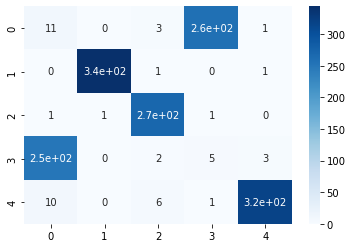

In [122]:
sns.heatmap(confusion_matrix(ytdf['test'], yp), annot=True, cmap='Blues')


The highest accuracy I managed to obtain was 0.638 by settings the following hyperparameters :<a id="1"></a>
- min_df=5
- solver : 'mu'
- beta_loss : 'kullback-leibler'

### Comparison to Supervised Learning Methods

In [142]:
models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LogisticRegression(random_state=0)]

CV = 5  # Cross Validate with 3 different folds of 20% data ( 80-20 split with 5 folds )

#Create a data frame that will store the results for all 5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

#For each Algorithm 
for model in models:
  model_name = model.__class__.__name__
  # create 5 models with different 20% test sets, and store their accuracies
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

<AxesSubplot:xlabel='model_name', ylabel='accuracy'>

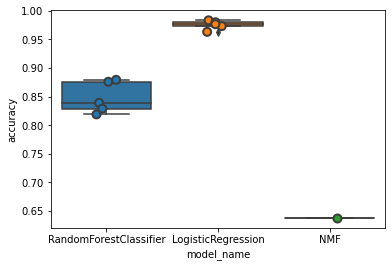

In [155]:
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
df2 = {'model_name': 'NMF', 'accuracy': accuracy_score(ytdf['test'], yp)}
cv_df = cv_df.append(df2, ignore_index = True)

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [156]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.975168
NMF                       0.637584
RandomForestClassifier    0.848322
Name: accuracy, dtype: float64